# 这是一个给beginner的一个pytorch教程
* author:李昊佳 email wisderek@stumail.neu.edu.cn    

## Motivation
我希望能通过一个简单的mnist的数字识别的例子实现pytorch的入门学习,能让初学者快速完成一个实例，激起大家深入学习的兴趣     
我会尽量对每个部分进行详细的注释说明，同时加入一些我见过的小trick，希望能对初学者有帮助   
本教程基于pytorch 1.4进行（1.0以上应该都可以）  
依赖matplotlib numpy pytorch juypter  
PS（自动选择是否用gpu，配置要求极低，我在我的 双核i5 笔记本上 8G内存 只有核显都可以正常运行 ）

## basic 基础知识
### 张量(Tensor)
其实就是个数组，但是这是pytorch用的，可以在GPU上计算


In [1]:
%matplotlib inline
import torch        #最基本的torch

In [2]:
x = torch.Tensor(3, 3)  # 构建一个未初始化的5*3的矩阵
print(x)                
y = torch.randn_like(x,dtype=torch.float) #构建一个同样大小的随机矩阵 并覆盖类型
print(y)
print(x + y)    # 加法
res = torch.empty(3,3)
torch.add(x,y,out=res)  #输出到指定Tensor
print(res)
# 把x加到y上 原地操作
y.add_(x)

tensor([[1.3563e-19, 1.3563e-19, 1.3563e-19],
        [1.3563e-19, 1.4013e-45, 1.1866e+27],
        [0.0000e+00, 0.0000e+00, 2.0590e+23]])
tensor([[ 1.4230,  0.4047, -0.1163],
        [ 1.2562,  2.2146,  0.7222],
        [-0.3109,  0.4679, -1.3644]])
tensor([[ 1.4230e+00,  4.0473e-01, -1.1633e-01],
        [ 1.2562e+00,  2.2146e+00,  1.1866e+27],
        [-3.1094e-01,  4.6788e-01,  2.0590e+23]])
tensor([[ 1.4230e+00,  4.0473e-01, -1.1633e-01],
        [ 1.2562e+00,  2.2146e+00,  1.1866e+27],
        [-3.1094e-01,  4.6788e-01,  2.0590e+23]])


tensor([[ 1.4230e+00,  4.0473e-01, -1.1633e-01],
        [ 1.2562e+00,  2.2146e+00,  1.1866e+27],
        [-3.1094e-01,  4.6788e-01,  2.0590e+23]])

** 注意**

任何在原地(in-place)改变张量的操作都有一个`_`后缀。例如`x.copy_(y)`, `x.t_()`操作将改变x.  
你可以使用各种类似标准NumPy的花哨的索引功能

In [3]:
print(x[:, 1]) #索引第一列

tensor([1.3563e-19, 1.4013e-45, 0.0000e+00])


## Step 1 使用torch.nn包来构建神经网络
对于这部分不太熟悉的同学 强烈安利这个  
[CNN 基础](https://github.com/zergtant/pytorch-handbook/blob/master/chapter2/2.4-cnn.ipynb)
### 网络结构   

![alt network](img/network.png)

1. 5*5卷积 1 in channels 6 out channels 
2. 最大池化
3. 3*3 卷积 6 in channels 16 out channels 
4. 最大池化
5. 全连接 120
6. 全连接 84
7. 输出   10  
### 卷积计算  
#### 卷积核大小 f
卷积核方块的大小，我们这里用f来表示

#### 边界填充 (p)adding
不用padding 经过计算后矩阵的大小改变了，如果要使矩阵大小不改变呢，我们可以先对矩阵做一个填充，将矩阵的周围全部再包围几层，能够使最后卷积出来大小不变，包围层数为p

#### 步长 (s)tride
每次滑动距离。

#### 计算公式

n为我们输入的矩阵的大小，$ \frac{n-f+2p}{s} +1 $ 向下取整
### 训练过程
* 定义神经网络模型
* 加载数据集
* 输入数据(可能需要进行一些归一化之类的操作)
* 计算损失(输出结果和正确值的差距大小)
* 将梯度反向传播为网络的参数(通常使用自动求导工具)
* 更新网络的参数,主要使用如下简单的更新原则:`weight = weight - learning_rate * gradient`

In [4]:
%matplotlib inline
import torch                    #加载pytorch
import torch.nn as nn           #加载nn包来构建神经网络
import torch.nn.functional as F #加载给定的functional

Device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 让torch判断是否使用GPU
class CNN_Net(nn.Module):           #继承nn.module
    def __init__(self):
        super(CNN_Net,self).__init__()
        # 这里是模型中有参数的层，需要声明独立的变量
        self.conv1 = nn.Conv2d(1, 6, (5,5))     #第一个卷积 1 in channels 6 out channels 5*5卷积
        self.conv2 = nn.Conv2d(6, 16, 3)    #第二个卷积 6 in channels 16 out channels 5*5卷积 （长宽一样只用写一个）
        #全连接层 y = Wx + b
        self.fc1 = nn.Linear(16*5*5, 120)     #线性层 output 120
        self.fc2 = nn.Linear(120, 84)       #线性层 output 84
        self.fc3 = nn.Linear(84, 10)        #线性层 output 10

    #定义前往网络 !!!重要
    def forward(self, x):
        in_size = x.size(0) #表示batch大小
        out = self.conv1(x)   #卷积
        out = F.relu(out)       #激活函数
        out = F.max_pool2d(out, (2,2))  # 2*2池化
        #到这里已经过了一个卷积 一个池化 中间用relu做激活函数
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)      # 2*2池化 （长宽一样只用写一个）
        #到这里已经完成了两次卷积和池化 之后是要进入全连接层
        out = out.view(-1, 16*5*5) # 这里是展开2维的变成一维的 
        # view(2,3)相当于把一个含有6个量的Tensor变成2*3形式  用-1表示自动确定大小
        out = F.relu(self.fc1(out)) #全连接
        out = F.relu(self.fc2(out)) #全连接
        # 输出层
        out = self.fc3(out)
        #out = F.log_softmax(out,dim=1)
        return out
### 使用autograd工具会自动创建 backward 
# 查看网络结构
model = CNN_Net()

print(Device,model)


cuda CNN_Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Step 2 加载数据集
数据是深度学习十分宝贵的资源
* 通常我们数据加载可以用标准的python方法来实现,我们加载到一个numpy数组中然后转换为pytorch中tensor
* 在实际中我们会便写一个dataset类 来实现加载，这里为了更快看到结果我们把这一部分放在后面，我们先使用pytorch自带的方法

torch.Size([60000, 28, 28])


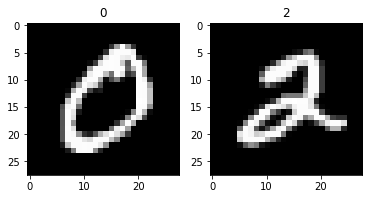

In [5]:
# TODO: add dataset class
from torchvision import datasets,transforms  #torchvison 提供了一些常用的视觉相关的方法
import torch.utils.data as Data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt         #可视化
# 注意如果下载慢的话自行到lecun网站上下载 http://yann.lecun.com/exdb/mnist/
train_set = datasets.MNIST('./data', train=True, download=True,transform=transforms.Compose([
    transforms.ToTensor()
    ]))  #加载训练数据集
test_set = datasets.MNIST('./data', train=False, download=True,transform=transforms.Compose([
    transforms.ToTensor()
    ]))  #加载测试用数据集 transform 一定要加 转化为pytorch认识的

## ！！重要
Batch_size = 160 #这个代表你每次希望多少个图片同时训练
Shuffle = True #训练时候是否打乱顺序
train_loader = DataLoader(train_set,batch_size=Batch_size, shuffle=Shuffle)
test_loader  = DataLoader(test_set,batch_size=Batch_size, shuffle=Shuffle)

#可视化 可以直接跳过
print(train_set.train_data.size())     # (60000, 28, 28)    #显示大小
plt.subplot(1,2,1)
plt.imshow(train_set.train_data[1].numpy(), cmap='gray')  # train_data[1]
plt.title('%i' % train_set.train_labels[1])  
plt.subplot(1,2,2)
plt.imshow(train_set.train_data[5].numpy(), cmap='gray')  # train_data[5]
plt.title('%i' % train_set.train_labels[5])  
plt.show()

## Step 3构建优化器 
在反向传播计算完所有参数的梯度后，还需要使用优化方法来更新网络的权重和参数，

In [6]:
'''
构建优化器 在反向传播计算完所有参数的梯度后，还需要使用优化方法来更新网络的权重和参数，
例如随机梯度下降法(SGD)的更新策略
weight = weight - learning_rate * gradient
'''
import torch.optim as optim
LR = 0.01  #学习率
optimizer = optim.Adam(model.parameters(),lr=LR)

# 训练
这一部分很重要！这是一般的训练流程
* 输入数据(可能需要进行一些归一化之类的操作)
* 计算损失(输出结果和正确值的差距大小)
* 将梯度反向传播为网络的参数(通常使用自动求导工具)
* 更新网络的参数
## Step 4 编写训练流程

In [7]:
import torch.nn as nn #CrossEntropyLoss 现在在nn里面不在functional里面

def train(model, epoch, optimizer, train_loader):
    model.train()   #切换为训练模式 主要是自动求导
    for batch_idx, (data, target) in enumerate(train_loader):   #迭代每个batch
        data =  data.to(Device)
        target =  target.to(Device)       #将数据转化到要训练的地方
        optimizer.zero_grad()   # 先梯度清零(与model.zero_grad()效果一样)
        output = model(data)    # 前向传播（网络计算结果）
        # 计算损失函数
        #注意新的pytorch需要这么写 或者nn.CrossEntropyLoss()(output, target)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        #自动求导 并进行反向传播
        loss.backward()
        #更新模型参数
        optimizer.step()
        # 训练过程监视
        if(batch_idx+1)%30 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def show_model_params(model):
    for name,parameters in model.named_parameters():
        print(name,':',parameters.size())   #显示模型参数
show_model_params(model)

conv1.weight : torch.Size([6, 1, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 3, 3])
conv2.bias : torch.Size([16])
fc1.weight : torch.Size([120, 400])
fc1.bias : torch.Size([120])
fc2.weight : torch.Size([84, 120])
fc2.bias : torch.Size([84])
fc3.weight : torch.Size([10, 84])
fc3.bias : torch.Size([10])


* tips  
pytorch中CrossEntropyLoss是通过两个步骤计算出来的:  
第一步是计算log softmax，第二步是计算cross entropy（或者说是negative log likehood），  
CrossEntropyLoss不需要在网络的最后一层添加softmax和log层，直接输出全连接层即可。     
而NLLLoss则需要在定义网络的时候在最后一层添加log_softmax层(softmax和log层)  
               
总而言之：`CrossEntropyLoss() = log_softmax() + NLLLoss()` 


## Step 5 编写测试函数
用来查看每一轮训练效果

In [8]:
import torch.nn as nn #CrossEntropyLoss 现在在nn里面不在functional里面
def test(model, test_loader):
    model.eval()    #评估网络
    test_loss = 0
    correct = 0
    with torch.no_grad():   #取消自动求导 加快速度
        for data, target in test_loader:
            data, target = data.to(Device), target.to(Device)
            output = model(data)    #利用网络进行预测
            #注意新的pytorch需要这么写或者nn.CrossEntropyLoss()(output, target)
            criterion = nn.CrossEntropyLoss(reduction='sum')    
            test_loss += criterion(output, target).item() # 将一批的损失相加
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标,也就是预测值
            correct += pred.eq(target.view_as(pred)).sum().item()   #求正确的个数

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Step 6 调用函数开始训练

In [9]:
model = model.to(Device)  #将模型放在GPU或者CPU上
Epoches = 10
for epoch in range(1, Epoches + 1):
    train(model, epoch,optimizer,train_loader)
    test(model, test_loader)

Train Epoch: 1 [4640/60000 (8%)]	Loss: 0.603595
Train Epoch: 1 [9440/60000 (16%)]	Loss: 0.142448
Train Epoch: 1 [14240/60000 (24%)]	Loss: 0.158628
Train Epoch: 1 [19040/60000 (32%)]	Loss: 0.087429
Train Epoch: 1 [23840/60000 (40%)]	Loss: 0.055819
Train Epoch: 1 [28640/60000 (48%)]	Loss: 0.105634
Train Epoch: 1 [33440/60000 (56%)]	Loss: 0.136963
Train Epoch: 1 [38240/60000 (64%)]	Loss: 0.054828
Train Epoch: 1 [43040/60000 (72%)]	Loss: 0.098460
Train Epoch: 1 [47840/60000 (80%)]	Loss: 0.126508
Train Epoch: 1 [52640/60000 (88%)]	Loss: 0.048789
Train Epoch: 1 [57440/60000 (96%)]	Loss: 0.099739

Test set: Average loss: 0.0569, Accuracy: 9821/10000 (98.210%)

Train Epoch: 2 [4640/60000 (8%)]	Loss: 0.047434
Train Epoch: 2 [9440/60000 (16%)]	Loss: 0.054902
Train Epoch: 2 [14240/60000 (24%)]	Loss: 0.053057
Train Epoch: 2 [19040/60000 (32%)]	Loss: 0.106474
Train Epoch: 2 [23840/60000 (40%)]	Loss: 0.082733
Train Epoch: 2 [28640/60000 (48%)]	Loss: 0.076496
Train Epoch: 2 [33440/60000 (56%)]	Loss: 

理论上你的模型应该能达到98%左右的准确度  
现在来说mnist识别是深度学习十分简单的任务  
要是没达到请仔细检查一下

## Step 7 保存训练后的模型
为了方便后来使用我们把网络模型保存下来

In [10]:
# 这两种方法二选一即可，推荐只保存模型参数
# 仅保存模型参数
torch.save(model.state_dict(), 'model/net_params.pkl')

In [11]:
# 保存整个网络结构
torch.save(model, 'model/net.pkl')

## End step 加载训练好的模型，并测试

In [12]:
# 对于仅保存参数的模型
# 注意这个model是之前定义的cnn_net的model
model_load_params = CNN_Net()
model_load_params
model_load_params.load_state_dict(torch.load("model/net_params.pkl"))
model_load_params.to(Device)
test(model_load_params,test_loader)


Test set: Average loss: 0.0504, Accuracy: 9861/10000 (98.610%)



In [13]:
#对于保存整个网络的
model_allnet = torch.load('model/net.pkl')
test(model_allnet,test_loader)


Test set: Average loss: 0.0504, Accuracy: 9861/10000 (98.610%)



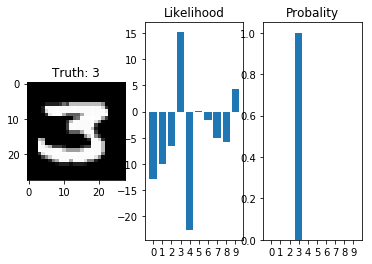

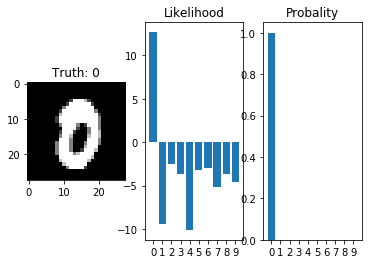

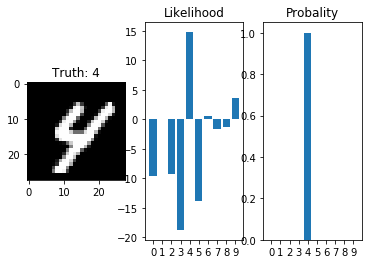

In [14]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt         #可视化
# review 用网络进行预测
model = model_load_params # model = model_allnet
model.to(Device)
# 这里只取一个batch 就不用循环了
dataiter = iter(train_loader)
images, labels = dataiter.next()
data, labels = images.to(Device), labels.to(Device)
output = model(data)    #利用网络进行预测 关键 output存放的就是各个类别的可能性
pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标,也就是预测值
# 可视化一下 直观一点
for i in range(min(len(images),3)):
    plt.subplot(1,3,1)
    plt.imshow(images[i].view(28,28).numpy(), cmap='gray') 
    plt.title('Truth: %i' % labels[i])  
    plt.subplot(1,3,2)
    plt.title("Likelihood")
    plt.bar(range(0,10),output[i].detach().cpu().numpy())
    plt.xticks(range(0,10), range(0,10), rotation=0)#rotation控制倾斜角度
    plt.subplot(1,3,3)
    plt.title("Probality")  
    # 进行一次softmax 把变成概率值 关键
    prob_output = F.softmax(output[i],dim=0)
    plt.bar(range(0,10),prob_output.detach().cpu().numpy())
    plt.xticks(range(0,10), range(0,10), rotation=0)#rotation控制倾斜角度
    plt.show()

# 学习资源  
特别好的[pytorch_handbook](https://github.com/zergtant/pytorch-handbook)